# Japanese Handwrite Classifer


##Training

In [26]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import math
import random
import csv

# Pytorch
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split


# For plotting learning curve
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
from torch.optim.lr_scheduler import CosineAnnealingLR,CosineAnnealingWarmRestarts,StepLR

# Visualization
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

from pathlib import Path

##Parameter

In [27]:
device = "cuda" if torch.cuda.is_available() else "cpu"
config = {
    "dataset_path": '/content/drive/MyDrive/hiragana_images',
    "output_path": './models/model.pt',
    "n_epoch": 340,
    "batch_size": 32,
    'learning_rate': 1.08,
    "img_size": (64, 64),
    "seed": 416,
    "valid_size": 0.15,
    "num_class": 50
}

In [28]:
def same_seed(seed):
    # Fixes random number generator seeds for reproducibility
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # same data
    np.random.seed(seed)
    torch.manual_seed(seed) # torch+CPU
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed) # torch+GPU

def accuracy(pred: torch.Tensor, label: torch.Tensor):
    _, pred_label = pred.max(1)
    num_correct = (pred_label == label).sum().item()
    acc = num_correct / label.shape[0]
    return acc

##Dataset

In [29]:
class Dataset1(Dataset):
  def __init__(self, images, labels, transform=None):
    self.images = images
    self.labels = labels
    self.transform = transform
    self.num_class = config['num_class']

  def __len__(self):
    return int(self.images.shape[0])

  def __getitem__(self, index):
    image = self.images[index]
    label = self.labels[index]

    # if self.transform:
    image = self.transform(image)

    return image, label

In [30]:
class Japanese_Dataset(Dataset):
  def __init__(self, path, tfm, files = None):
    super(Japanese_Dataset).__init__()
    self.path = path
    self.files = sorted([os.path.join(path,x) for x in os.listdir(path) if x.endswith(".jpg")])

    if files != None:
      self.files = files
    print(f"One {path} sample",self.files[0]) 
    self.transform = tfm
    self.number = ['0','1','2','3','4','5','6','7','8','9']

  def __len__(self):
    return len(self.files)

  def __getitem__(self,idx):
    fname = self.files[idx]
    img = Image.open(fname)
    img = self.transform(img)
    
    st = ""
    fname = fname.split('/')[-1].split('.')[0].split('kana')[1]
    for s in fname:
      if s not in self.number:
        st += s
    label = roman50_dict_inv[st]

    return img, label

##Model

###1.Resnet

In [31]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
            nn.BatchNorm2d(out_channels)
        )
        
    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        if x.size() != out.size():
            identity = self.downsample(x)
            
        out += identity
        out = self.relu(out)
        
        return out


class ResNet9(nn.Module):
    def __init__(self, num_classes=50):
        super(ResNet9, self).__init__()
        self.in_channels = 16
        
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        
        self.block1 = self.make_block(16, 16, stride=1)
        self.block2 = self.make_block(16, 32, stride=2)
        self.block3 = self.make_block(32, 64, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, num_classes)
        
    def make_block(self, in_channels, out_channels, stride):
        layers = []
        layers.append(BasicBlock(in_channels, out_channels, stride))
        self.in_channels = out_channels
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        
        return out

###2.VGG


*   layer1:兩層3x3Conv+Maxpooling+Dropout
*   layer2:兩層3x3Conv+Maxpooling+Dropout
*   fully connected:(64x13x13) : 256: 50






In [32]:
class JA_NN(nn.Module):
  def __init__(self, num_classes=50):
    super(JA_NN, self).__init__()
    
    self.conv_layer1 = nn.Sequential(
      nn.Conv2d(1, 32, kernel_size=3, stride=1),
      nn.ReLU(),
      nn.Conv2d(32, 32, kernel_size=3, stride=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Dropout(0.5)
    )

    self.conv_layer2 = nn.Sequential(
      nn.Conv2d(32, 64, kernel_size=3, stride=1),
      nn.ReLU(),
      nn.Conv2d(64, 64, kernel_size=3, stride=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Dropout(0.5)    
    )

    self.conv_layer3 = nn.Sequential(
      nn.Conv2d(64, 128, kernel_size=3, stride=1),
      nn.ReLU(),
      nn.Conv2d(128, 128, kernel_size=3, stride=1),
      nn.ReLU(),
      nn.Conv2d(128, 128, kernel_size=3, stride=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Dropout(0.5)    
    )

    self.flatten = nn.Flatten()

    self.fc = nn.Sequential(
      nn.Linear(64 * 13 * 13, 512),
      nn.ReLU(),
      nn.Dropout(0.5),
      nn.Linear(512, num_classes)
    )

    # self.softmax = nn.Softmax(dim=1)

  def forward(self, x):
    x = self.conv_layer1(x)

    x = self.conv_layer2(x)

    # x = self.conv_layer3(x)
    
    x = self.flatten(x)

    x = self.fc(x)

    # x = self.softmax(x)
    return x

##Data Argumentation

In [33]:
def add_gaussian_noise(img, scale=0.1):
  # 轉換為 NumPy 陣列
  img_np = np.array(img)
  # 產生高斯雜訊
  noise = np.random.normal(loc=0, scale=scale, size=img_np.shape)
  # 將雜訊加到圖片上
  img_noisy = img_np + noise
  # 將值限制在 [0, 1] 範圍內
  img_noisy = np.clip(img_noisy, 0, 1)
  # 轉換回 PIL 影像
  img_noisy_pil = Image.fromarray((img_noisy * 255).astype(np.uint8))

  return img_noisy_pil

train_tfm = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(30),  # 随机旋转范围为 -30 度到 +30 度
    transforms.RandomAffine(0, translate=(0.1, 0.1)),  # 随机平移范围为 (-0.1, -0.1) 到 (0.1, 0.1)
    transforms.Resize(config['img_size']),
    transforms.Lambda(lambda img: add_gaussian_noise(img, scale=0.15)),
    transforms.ToTensor(),
])

train_tfm2 = transforms.Compose([
    transforms.RandomRotation(30),  # 随机旋转范围为 -30 度到 +30 度
    transforms.RandomAffine(0, translate=(0.1, 0.1)),  # 随机平移范围为 (-0.1, -0.1) 到 (0.1, 0.1)
    transforms.Resize(config['img_size']),
    transforms.Lambda(lambda img: add_gaussian_noise(img, scale=0.15)),
    transforms.ToTensor(),
])

valid_tfm = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.RandomRotation(30),  # 随机旋转范围为 -30 度到 +30 度
    transforms.RandomAffine(0, translate=(0.1, 0.1)),  # 随机平移范围为 (-0.1, -0.1) 到 (0.1, 0.1)
    transforms.Resize(config['img_size']),
    transforms.Lambda(lambda img: add_gaussian_noise(img, scale=0.15)),
    transforms.ToTensor(),
])

test_tfm = transforms.Compose([
    transforms.Resize(config['img_size']),
    transforms.ToTensor(),
])

##Load Data

In [34]:
img_npz = np.load('/content/hiragana.npz')
array_names = img_npz.files
print(array_names)  # 打印数组名字
img = img_npz['arr_0']

['arr_0']


In [35]:
img_data = np.load("hiragana.npz")['arr_0'].reshape([-1, 127, 128]).astype(np.float32)
label = np.repeat(np.arange(config['num_class']), 160)

###Data Label

In [36]:
cate = {
    'A': 0, 'BA': 1, 'CHI': 2, 'DA': 3, 'E': 4, 'FU': 5, 'HA': 6, 'HE': 7, 'HI': 8, 'HO': 9, 'I': 10, 'JI': 11,
    'KA': 12, 'KE': 13, 'KI': 14, 'KO': 15, 'KU': 16, 'MA': 17, 'ME': 18, 'MI': 19, 'MO': 20, 'MU': 21, 'N': 22,
    'NA': 23, 'NE': 24, 'NI': 25, 'NO': 26, 'NU': 27, 'O': 28, 'PI': 29, 'RA': 30, 'RE': 31, 'RI': 32, 'RO': 33,
    'RU': 34, 'SA': 35, 'SE': 36, 'SHI': 37, 'SO': 38, 'SU': 39, 'TA': 40, 'TE': 41, 'TO': 42, 'TSU': 43, 'U':
    44, 'WA': 45, 'WO': 46, 'YA': 47, 'YO': 48, 'YU': 49}

roman71 = ['A','I','U','E','O','KA','GA','KI','GI','KU','GU','KE','GE','KO','GO','SA','ZA','SHI','JI','SU','ZU','SE','ZE','SO','ZO',
      'TA','DA','CHI','Ji','TSU','Zu','TE','DE','TO','DO','NA','NI','NU','NE','NO','HA','BA','PA','HI','BI','PI','FU','BU','PU',
      'HE','BE','PE','HO','BO','PO','MA','MI','MU','ME','MO','YA','YU','YO','RA','RI','RU','RE','RO','WA','WO','N']

roman71_idx = [i for i in range(len(roman71))]
roman71_dict = dict(zip(roman71_idx, roman71))
roman71_dict_inv = {v: k for k, v in roman71_dict.items()}

origin_roman50 = ['A','I','U','E','O','KA','KI','KU','KE','KO','SA','SHI','JI','SU','SE','SO','TA','DA','CHI','TSU','TE','TO',
        'NA','NI','NU','NE','NO','HA','BA','HI','PI','FU','HE','HO','MA','MI','MU','ME','MO','YA','YU','YO','RA',"RI",
        'RU','RE','RO','WA','WO','N']
sorted_roman50 = sorted(origin_roman50)

roman50_idx = [i for i in range(len(sorted_roman50))]
roman50_dict = dict(zip(roman50_idx, sorted_roman50))
roman50_dict_inv = {v: k for k, v in roman50_dict.items()}

indices = []
for i in sorted_roman50:
  indices.append(roman71_dict_inv[i])
remain_idx = []
for i in indices:
  # i = roman71_dict_inv[roman50_dict[i]]
  end = ((i + 1) * 160)
  start = end - 160
  for j in range(start, end):
    remain_idx.append(j)
img_data = img_data[remain_idx]

new_label = np.repeat(np.arange(config['num_class']), 160)

In [37]:
# normalization
norm_img = []
for img in img_data:
  min_val = np.min(img)
  max_val = np.max(img)

  # 归一化到 [0, 1]
  output = (img - min_val) / (max_val - min_val)
  norm_img.append(output)
norm_img = np.array(norm_img)

##Visualization

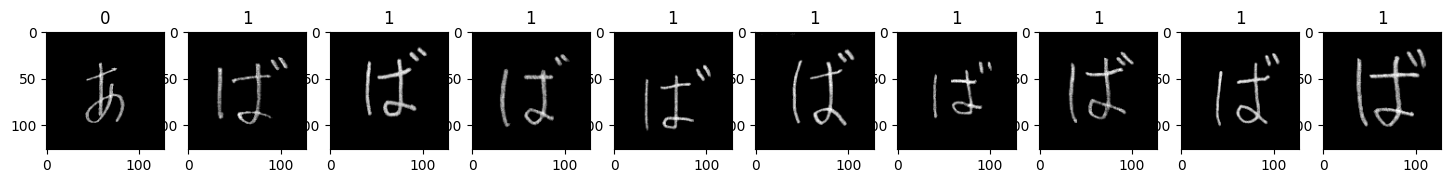

In [38]:
plt.figure(figsize=(18, 6))
a = 159

for i in range(10):
    plt.subplot(1, 10, i + 1)
    image = img_data[i+a]
    plt.imshow(image, cmap=plt.cm.gray)
    plt.title(label[i+a])

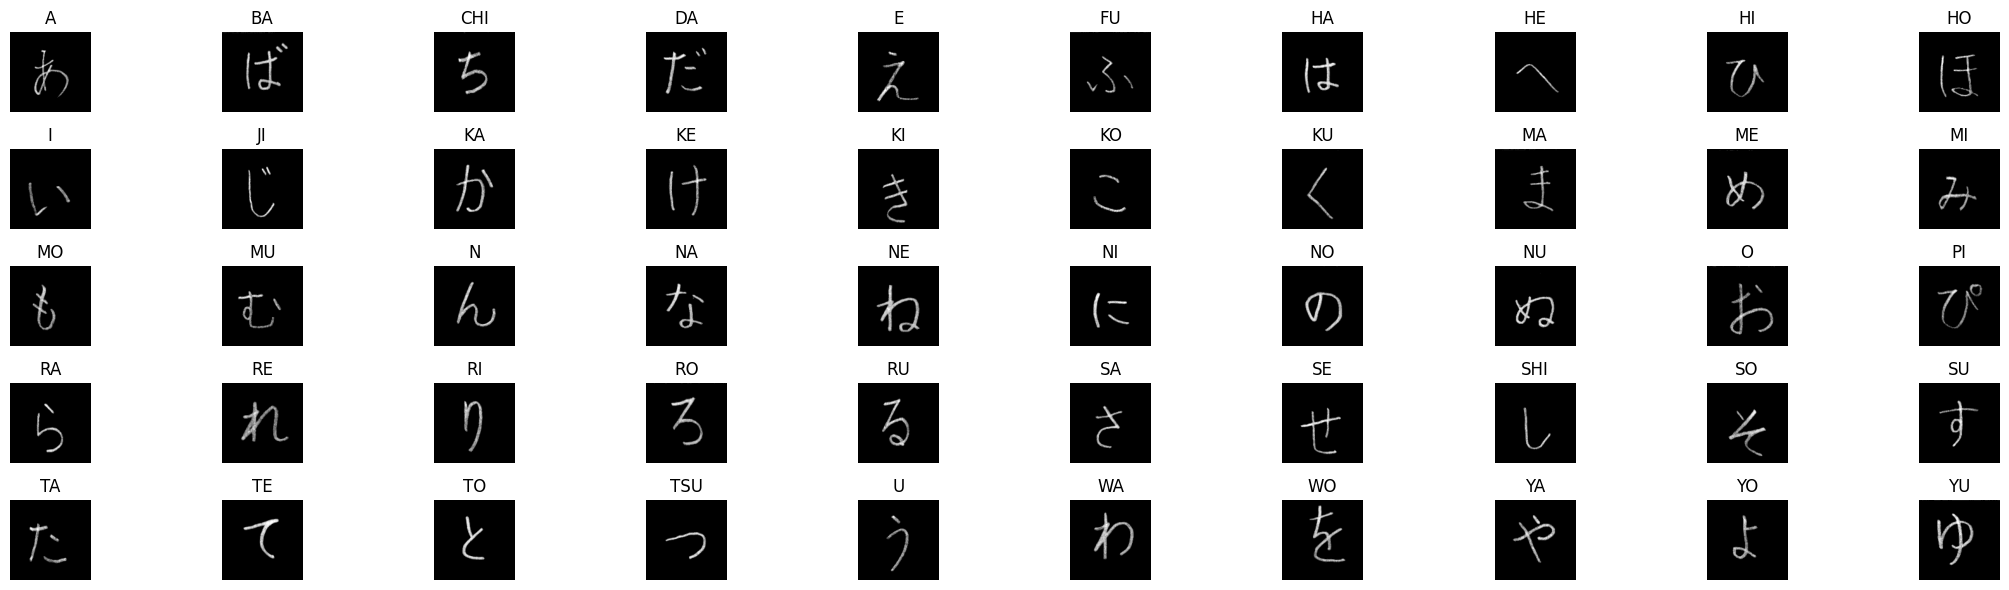

In [39]:
fig, axs = plt.subplots(5, 10, figsize=(22, 6))
count_img = 1

for i in range(5):
  for j in range(10):
    # index = count_img * 160 + j  # 计算照片在数组中的索引
    if count_img < len(img_data):
      axs[i, j].imshow(img_data[count_img], cmap=plt.cm.gray)  # 显示照片
      axs[i, j].axis('off')  # 关闭坐标轴
      axs[i, j].set_title(f"{roman50_dict[new_label[count_img]]}")
      count_img += 160
    else:
      axs[i, j].axis('off')  # 关闭未使用的子图

plt.tight_layout()

# 显示图形
plt.show()

In [40]:
import os

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
same_seed(config['seed'])

train_dataset = Dataset1(norm_img, label, transform=train_tfm)
total_samples = len(train_dataset)
valid_size = int(config['valid_size'] * total_samples)
train_size = total_samples - valid_size



train_dataset, valid_dataset = random_split(train_dataset, [train_size, valid_size])


# train_idx = random.sample(list(range(total_samples)), train_size)
# valid_idx = list(set(list(range(total_samples))) - set(train_idx))
# train_dataset = Dataset1(norm_img[train_idx], label[train_idx], transform=train_tfm)
# valid_dataset = Dataset1(norm_img[valid_idx], label[valid_idx], transform=valid_tfm)


train_dataloader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=config['batch_size'], shuffle=True)

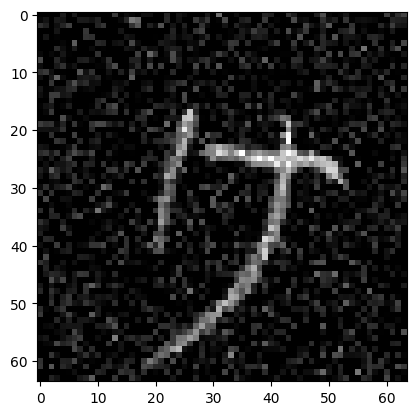

In [42]:
plt.imshow(train_dataset[462][0].squeeze(), cmap=plt.cm.gray)
plt.show()

##Training

In [43]:
n_epoch, lr, best_acc = config['n_epoch'], config['learning_rate'], 0

# build model
model = JA_NN().to(device)
# model = ResNet9().to(device)

# loss function
criterion = nn.CrossEntropyLoss().to(device)
# optimizer
# optimizer = torch.optim.SGD(model.parameters(), lr=config['learning_rate'])
# optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=1e-5)
optimizer = torch.optim.Adadelta(model.parameters(), lr=config['learning_rate'])

scheduler = CosineAnnealingWarmRestarts(optimizer,T_0=6,T_mult=7) 

if not os.path.isdir('./models'):
  os.mkdir('./models') 

# os.makedirs('./content/models', exist_ok=True)

n_epoch = config['n_epoch']
metric = {'train_loss': [], 'train_acc': [], 'valid_loss': [], 'valid_acc': []}
for i_epoch in range(n_epoch):
  print(f'Epoch[{i_epoch+1}/{n_epoch}]:') 
  train_loss = []
  train_acc = []
  model.train(mode=True)

  for i_batch, (image, label) in enumerate(train_dataloader):
    image = image.to(device)
    label = label.to(device)

    pred = model.forward(image)  # inference

    loss = criterion(pred, label)  # calculate loss
    optimizer.zero_grad()  # reset gradient to zero
    loss.backward()  # calculate gradient
    optimizer.step()  # optimize weight (using gradient)

    train_loss.append(loss.item())
    train_acc.append(accuracy(pred, label))
  scheduler.step()


  avg_loss = sum(train_loss)/ len(train_dataloader)
  avg_acc = sum(train_acc)/ len(train_dataloader)
  metric['train_loss'].append(avg_loss)
  metric['train_acc'].append(avg_acc)
  print(f'Training: loss: {avg_loss}, acc: {avg_acc}')

  model.eval()
  valid_loss = []
  valid_acc = []
  error_count = 0

  with torch.no_grad():
    for image, label in valid_dataloader:
      image = image.to(device)
      label = label.to(device)

      if label.size()[0] != config['batch_size']:             
        error_count += 1
        pass
      
      else:
        pred = model(image)

        loss = criterion(pred, label)  # calculate loss

        valid_loss.append(loss.item())
        valid_acc.append(accuracy(pred, label))

  avg_loss = sum(valid_loss) / (len(valid_dataloader) - error_count)
  avg_acc = sum(valid_acc) / (len(valid_dataloader) - error_count)
  metric['valid_loss'].append(avg_loss)
  metric['valid_acc'].append(avg_acc)
  print(f'Valid: loss: {avg_loss}, acc: {avg_acc}')

  # save models
  if metric['valid_acc'][-1] > best_acc:
    print(f"Best accuracy in epoch {i_epoch+1} / {n_epoch}, saving model...")

    torch.save(model, 'model.pt') 
    model_path = Path(config['output_path'])
    model_path.parent.mkdir(parents=True, exist_ok=True)
    torch.jit.script(model).save(model_path)
    
    best_acc = metric['valid_acc'][-1]
  print('\n')

Epoch[1/340]:
Training: loss: 3.914883723281359, acc: 0.018926056338028168
Valid: loss: 3.9146732252997323, acc: 0.016891891891891893
Best accuracy in epoch 1 / 340, saving model...


Epoch[2/340]:
Training: loss: 3.9136553448690496, acc: 0.017458920187793426
Valid: loss: 3.9163666931358545, acc: 0.015202702702702704


Epoch[3/340]:
Training: loss: 3.9131341607357975, acc: 0.01643192488262911
Valid: loss: 3.916890614741557, acc: 0.014358108108108109


Epoch[4/340]:
Training: loss: 3.912403529798481, acc: 0.021273474178403758
Valid: loss: 3.917637754131008, acc: 0.013513513513513514


Epoch[5/340]:
Training: loss: 3.9120529459116047, acc: 0.02112676056338028
Valid: loss: 3.9177968308732316, acc: 0.013513513513513514


Epoch[6/340]:
Training: loss: 3.911525808029891, acc: 0.020246478873239437
Valid: loss: 3.9177591220752612, acc: 0.014358108108108109


Epoch[7/340]:
Training: loss: 3.9133756171929446, acc: 0.018779342723004695
Valid: loss: 3.916906852979918, acc: 0.014358108108108109


E

##Loss and Accuracy

###Training

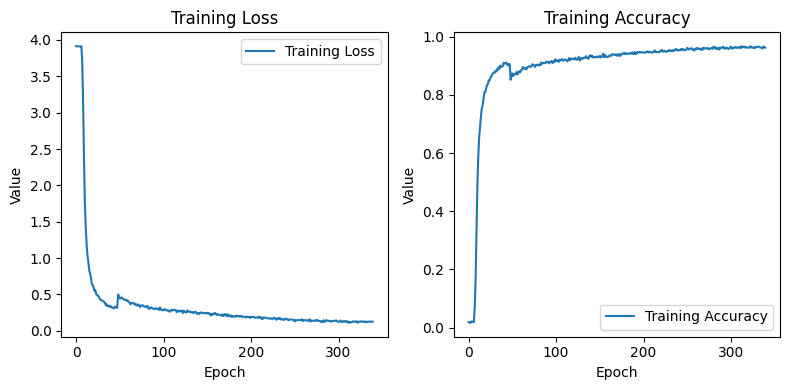

In [44]:
# 创建图形对象
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# 绘制 loss 曲线
ax1.plot(metric['train_loss'], label='Training Loss')

# 添加图例
ax1.legend()

# 添加轴标签
ax1.title.set_text('Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Value')

# 绘制 accuracy 曲线
ax2.plot(metric['train_acc'], label='Training Accuracy')
# 添加图例
ax2.legend()

# 添加轴标签
ax2.title.set_text('Training Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Value')

# 调整子图之间的间距
plt.tight_layout()
# 显示图形
plt.show()

###Vaildation

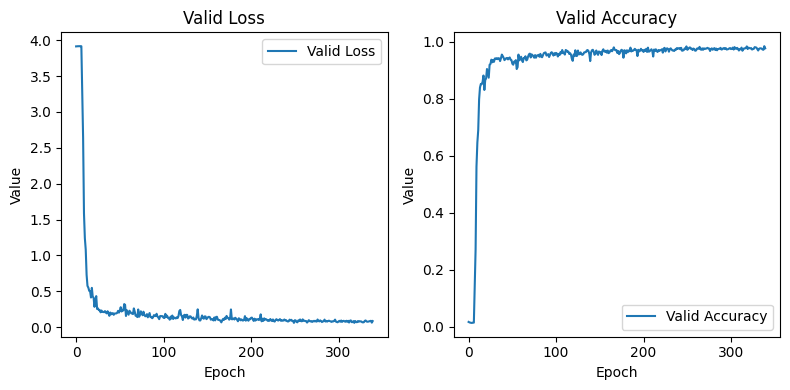

In [45]:
# 创建图形对象
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# 绘制 loss 曲线
ax1.plot(metric['valid_loss'], label='Valid Loss')
# 添加图例
ax1.legend()

# 添加轴标签
ax1.title.set_text('Valid Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Value')

# 绘制 accuracy 曲线
ax2.plot(metric['valid_acc'], label='Valid Accuracy')
# 添加图例
ax2.legend()

# 添加轴标签
ax2.title.set_text('Valid Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Value')

# 调整子图之间的间距
plt.tight_layout()
# 显示图形
plt.show()

##Test

In [46]:
test_dataset = Japanese_Dataset(path=config['dataset_path'], tfm=test_tfm)
test_dataloader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=True)

One /content/drive/MyDrive/hiragana_images sample /content/drive/MyDrive/hiragana_images/kanaA0.jpg


In [47]:
model.eval()
test_loss = []
test_acc = []
error_count = 0

with torch.no_grad():
  for image, label in test_dataloader:
    image = image.to(device)
    label = label.to(device)

    if label.size()[0] != config['batch_size']:
      error_count += 1
      pass
    
    else:
      pred = model(image)

      loss = criterion(pred, label)  # calculate loss

      test_loss.append(loss.item())
      test_acc.append(accuracy(pred, label))

avg_loss = sum(test_loss) / (len(test_dataloader))
avg_acc = sum(test_acc) / (len(test_dataloader))

print(f'Test: loss: {avg_loss}, acc: {avg_acc}')

Test: loss: 0.31454667390789837, acc: 0.880859375


In [48]:
trained_model = torch.jit.load(config['output_path'])
trained_model = trained_model.to(device)

trained_model.eval()
test_loss = []
test_acc = []

with torch.no_grad():
  for image, label in test_dataloader:
    image = image.to(device)
    label = label.to(device)

    # if label.size()[0] != config['batch_size']:
    #   error_count += 1
    #   print("aa")
    #   pass
    
    # else:
    pred = trained_model(image)

    loss = criterion(pred, label)  # calculate loss

    test_loss.append(loss.item())
    test_acc.append(accuracy(pred, label))

avg_loss = sum(test_loss) / (len(test_dataloader))
avg_acc = sum(test_acc) / (len(test_dataloader))

print(f'Test: loss: {avg_loss}, acc: {avg_acc}')

Test: loss: 0.32207928015850484, acc: 0.912109375


In [49]:
trained_model = torch.load('model.pt')
trained_model = trained_model.to(device)

trained_model.eval()
test_loss = []
test_acc = []

with torch.no_grad():
  for image, label in test_dataloader:
    image = image.to(device)
    label = label.to(device)

    # if label.size()[0] != config['batch_size']:
    #   error_count += 1
    #   print("aa")
    #   pass
    
    # else:
    pred = trained_model(image)

    loss = criterion(pred, label)  # calculate loss

    test_loss.append(loss.item())
    test_acc.append(accuracy(pred, label))

avg_loss = sum(test_loss) / (len(test_dataloader))
avg_acc = sum(test_acc) / (len(test_dataloader))

print(f'Test: loss: {avg_loss}, acc: {avg_acc}')

Test: loss: 0.3193108069463051, acc: 0.912109375
